### Model Stats CSV
Show info about the CSV file<br>
Show percentage of "is_better" overall and for each dataset

In [31]:
import pandas as pd

df = pd.read_csv('./model_stats.csv')
print(df.shape)

# Print percentage of "is_better" overall and for each dataset
print("\nPercentage of 'is_better' for each dataset:")
print((df.groupby(['dataset_name', 'dataset_group'])['scores_is_better']
    .value_counts(normalize=True) * 100))

print("\nPercentage of 'is_better' overall:")
print((df['scores_is_better'].value_counts(normalize=True) * 100))

(4320, 550)

Percentage of 'is_better' for each dataset:
dataset_name  dataset_group  scores_is_better
Gluonts       m1_monthly     True                70.138889
                             False               29.861111
              m1_quarterly   True                93.055556
                             False                6.944444
M3            Monthly        True                82.638889
                             False               17.361111
              Quarterly      True                59.027778
                             False               40.972222
Tourism       Monthly        False               90.277778
                             True                 9.722222
              Quarterly      False               81.944444
                             True                18.055556
Name: proportion, dtype: float64

Percentage of 'is_better' overall:
scores_is_better
True     55.439815
False    44.560185
Name: proportion, dtype: float64


### Feature Engineering (UNUSED)
Create new features:
- Calculate differences between consecutive steps for each layer
- ...

In [32]:
import pandas as pd
import re

df = pd.read_csv('./model_stats.csv')

# Define the layer steps you want to compare
steps = ['step_10', 'step_25', 'step_50', 'step_100', 'step_200', 'step_300', 'step_400', 'step_500']
layers = ['mlp.0', 'mlp.1', 'mlp.2']  # Adapt if you have more
stats = ['weight_mean', 'weight_std', 'weight_var', 'weight_frobenius_norm', 'weight_spectral_norm', 'weight_alpha_hat']  # etc.

# Find all relevant columns
pattern = re.compile(r'weights_step_(\d+)_mlp\.(\d+)\.(\w+)')
relevant_cols = [col for col in df.columns if pattern.match(col)]

# Compute diffs and store them in a dictionary first
features = {}

for stat in stats:
    for layer in layers:
        for i in range(1, len(steps)):
            prev_step = steps[i-1]
            curr_step = steps[i]
            col_prev = f'weights_{prev_step}_{layer}.{stat}'
            col_curr = f'weights_{curr_step}_{layer}.{stat}'
            if col_prev in df.columns and col_curr in df.columns:
                new_col = f'diff_{curr_step}_{prev_step}_{layer}_{stat}'
                features[new_col] = df[col_curr] - df[col_prev]

In [33]:
# # Concatenate all new features at once
# features_df = pd.DataFrame(features)
# df = pd.concat([df, features_df], axis=1)

# # Save or return the enhanced dataframe
# df.to_csv('./new_model_stats.csv', index=False)

## Stages Summary

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric_evolution(df, metrics, output_dir, task_name, include_error=False):
    os.makedirs(output_dir, exist_ok=True)

    for metric in metrics:
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"

        plt.figure(figsize=(10, 6))
        error_kwargs = {'yerr': df[std_col]} if include_error and std_col in df else {}
        
        plt.errorbar(
            df['stage'], df[mean_col],
            fmt='o-', capsize=5, label=metric,
            **error_kwargs
        )
        plt.ylabel(metric)
        plt.xlabel('Stage')
        plt.title(f"Evolution of '{metric}' ({task_name})")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend()
        plt.savefig(os.path.join(output_dir, f"{metric}_evolution.png"))
        plt.close()

# Classification metrics plot
CLASSIFICATION_METRICS = ['acc_score', 'roc_auc_score', 'log_loss_score', 'f1_score']
df_classification = pd.read_csv('./output/classification/stagewise_summary.csv')
plot_metric_evolution(df_classification, CLASSIFICATION_METRICS, "./output/images/classification", "Classification")

# Regression metrics plot
REGRESSION_METRICS = ['mae_score', 'mse_score', 'r2_score', 'pearson', 'kendall', 'spearman']
df_regression = pd.read_csv('./output/regression/stagewise_summary.csv')
plot_metric_evolution(df_regression, REGRESSION_METRICS, "./output/images/regression", "Regression")


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def ensure_dir_exists(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)

def plot_feature_importance_bar(df, step_column, output_path, task_name, top_n=20):
    if step_column not in df.columns:
        raise ValueError(f"Column '{step_column}' not found in DataFrame.")

    df_step = df[step_column].dropna().sort_values(ascending=True)

    if top_n:
        df_step = df_step[-top_n:]

    plt.figure(figsize=(10, max(6, len(df_step) * 0.3)))
    df_step.plot(kind='barh', color='skyblue')
    plt.xlabel("Importance")
    plt.title(f"Feature Importances ({task_name} - {step_column})")
    plt.tight_layout()

    ensure_dir_exists(output_path)
    plt.savefig(output_path)
    plt.close()

def plot_stacked_feature_importance(df, output_path, task_name, top_n=20, method='sum'):
    step_columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    df = df[step_columns].fillna(0)

    if method == 'sum':
        top_features = df.sum(axis=1).nlargest(top_n).index
    elif method == 'max':
        top_features = df.max(axis=1).nlargest(top_n).index
    else:
        raise ValueError("method must be 'sum' or 'max'")

    df_top = df.loc[top_features]
    bottom = pd.Series([0] * len(df_top), index=df_top.index)

    fig, ax = plt.subplots(figsize=(12, max(6, top_n * 0.4)))
    for step in step_columns:
        ax.barh(df_top.index, df_top[step], left=bottom, label=step)
        bottom += df_top[step]

    ax.set_xlabel("Total Importance")
    ax.set_title(f"Stacked Feature Importances Across Steps ({task_name})")
    ax.legend(title="Step", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    ensure_dir_exists(output_path)
    plt.savefig(output_path)
    plt.close()

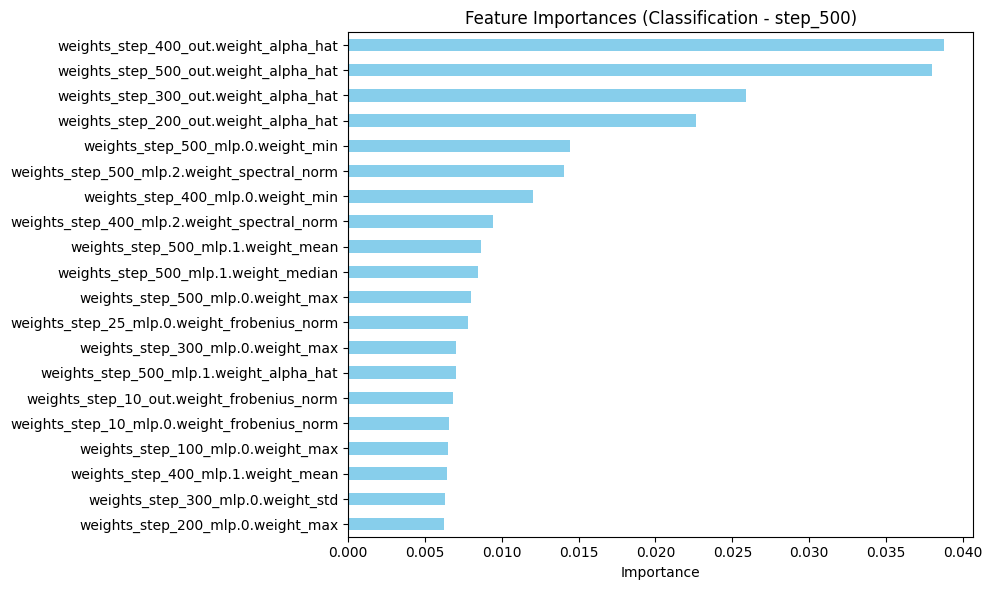

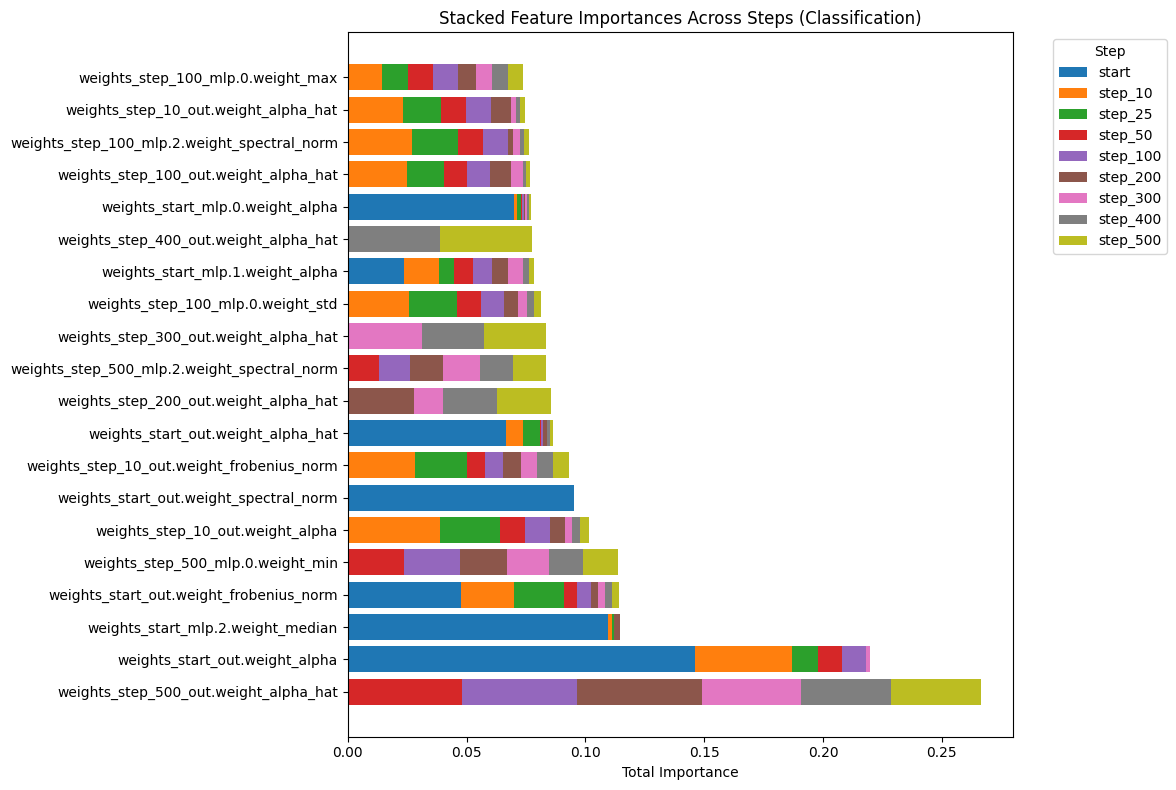

In [36]:
# === Classification ===
classification_csv = "./output/classification/feature_importance_values.csv"
classification_bar_path = "./output/images/classification/feature_importances_final_ranking.png"
classification_stacked_path = "./output/images/classification/stacked_feature_importances.png"
classification_df = pd.read_csv(classification_csv, index_col=0)

plot_feature_importance_bar(
    classification_df, step_column="step_500",
    output_path=classification_bar_path,
    task_name="Classification", top_n=20
)

plot_stacked_feature_importance(
    classification_df,
    output_path=classification_stacked_path,
    task_name="Classification",
    top_n=20
)

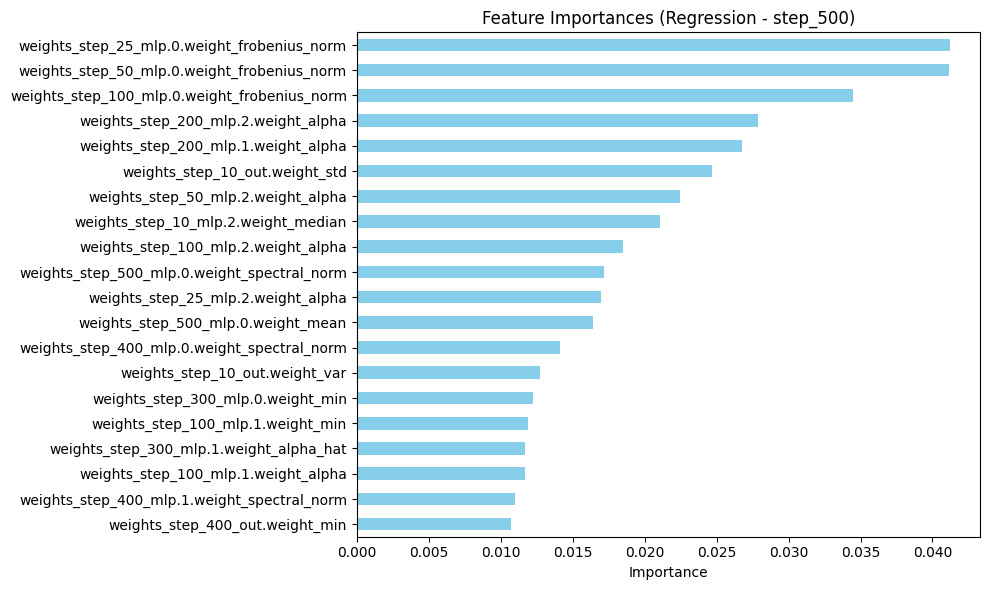

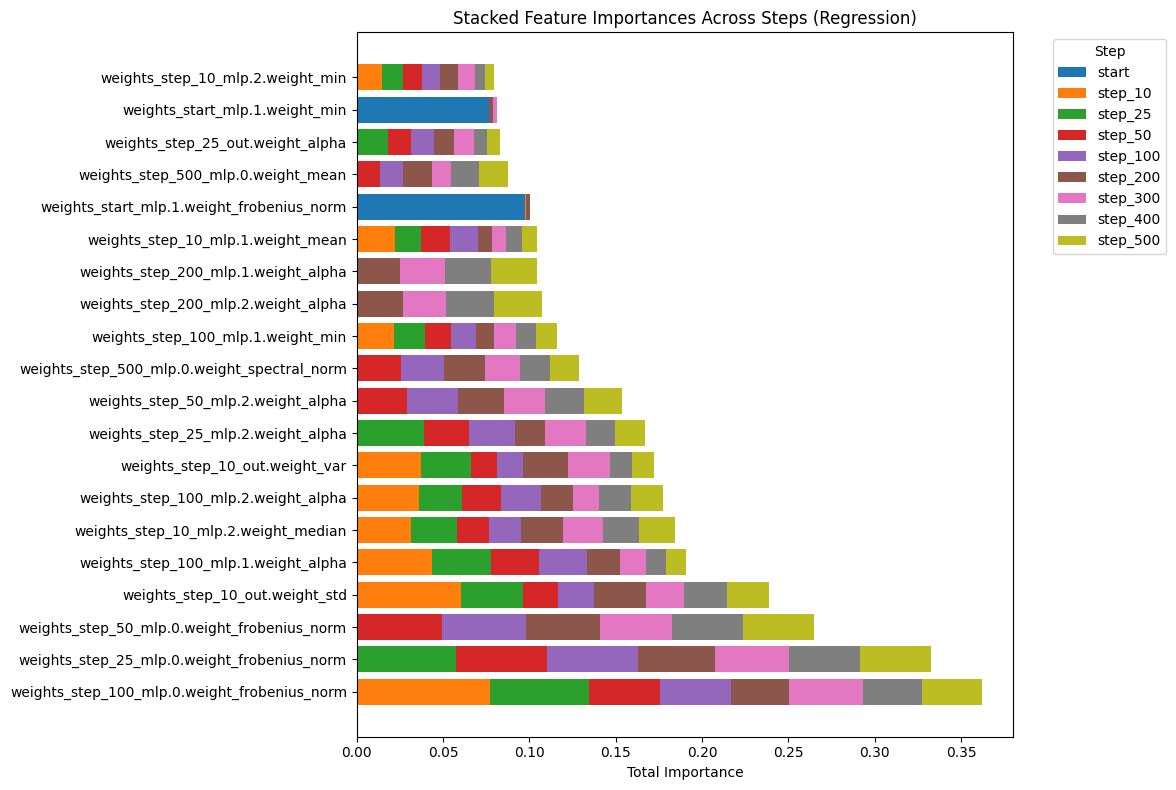

In [37]:
# === Regression ===
regression_csv = "./output/regression/feature_importance_values.csv"
regression_bar_path = "./output/images/regression/feature_importances_final_ranking.png"
regression_stacked_path = "./output/images/regression/stacked_feature_importances.png"
regression_df = pd.read_csv(regression_csv, index_col=0)

plot_feature_importance_bar(
    regression_df, step_column="step_500",
    output_path=regression_bar_path,
    task_name="Regression", top_n=20
)

plot_stacked_feature_importance(
    regression_df,
    output_path=regression_stacked_path,
    task_name="Regression",
    top_n=20
)

### Insights
* **Stage 10 Performance Drop**: Sharp degradation (highest MAE/MSE, lowest R² and correlations) indicates unstable learning early on.
* **Improvement Over Time**: MAE and MSE decline with more stages, showing better error control as training progresses.
* **Negative R² Throughout**: R² remains < 0 at all stages—model fits worse than a naive mean predictor.
* **Rank Correlation Improves**: Spearman and Kendall scores rise steadily to \~0.76, indicating good relative ranking of predictions.
* **Plateaus Detected**: Metrics stabilize after step\_100 and step\_400; performance gains flatten despite increased computation.
* **High Early Variance**: Step\_10 shows largest standard deviations—early predictions are inconsistent.
* **Time vs Benefit**: Time increases \~6× (3.45s → 22.04s) but error and correlation gains diminish after step\_100.
* **Actionable Insight**: Consider early stopping around step\_100–200; review model design to address poor absolute accuracy (negative R²).
* **Model Strength**: Performs well in ranking predictions, suitable for tasks where order matters more than exact values.